### DecisionTree Modelling 

### Import relevant libraries and dataset

In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

from joblib import dump, load

In [20]:
df = pd.read_csv('weatherAUS_imputed.csv')
display(df.head())
df.shape

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


(67725, 18)

In [21]:
#Before starting our modelling, we will define a ROC curve function to dipslay the results 
def roc_curve_custom(model, X, y):
    y_score = model.predict_proba(X)[:, 1] 
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model')
    roc_display.plot(color='orange', label=f'clf model (auc = {np.round(roc_auc,2)})')
    plt.grid(True)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random (auc = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [22]:
#We will also define a function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(y_test, y_pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### Decision Tree Classifier

### 1.Without over or undersampling

In [23]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1. Default Decision Tree with model with gini criterion and no max_depth

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

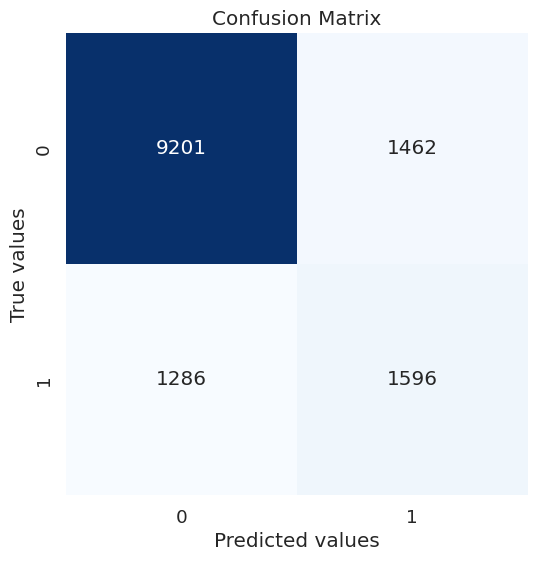

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     10663
         1.0       0.52      0.55      0.54      2882

    accuracy                           0.80     13545
   macro avg       0.70      0.71      0.70     13545
weighted avg       0.80      0.80      0.80     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.797


In [27]:
y_pred_test= dt.predict(X_test)
y_pred_train = dt.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train)

### 1.2 GridSearch

In [28]:
dtree_model = DecisionTreeClassifier(random_state=42)
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 12)}
nfolds = 5

In [29]:
grid_dt = GridSearchCV(dtree_model, param_grid, cv=nfolds)

In [30]:
dt_fit = grid_dt.fit(X_train, y_train)

In [31]:
dump(dt_fit, 'dt_fit.joblib')

['dt_fit.joblib']

In [32]:
dt_fit = load('dt_fit.joblib')
dt_fit.best_params_

{'criterion': 'entropy', 'max_depth': 8}

### 1.3 Model with best parameters

In [28]:
dt_best = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
dt_best.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

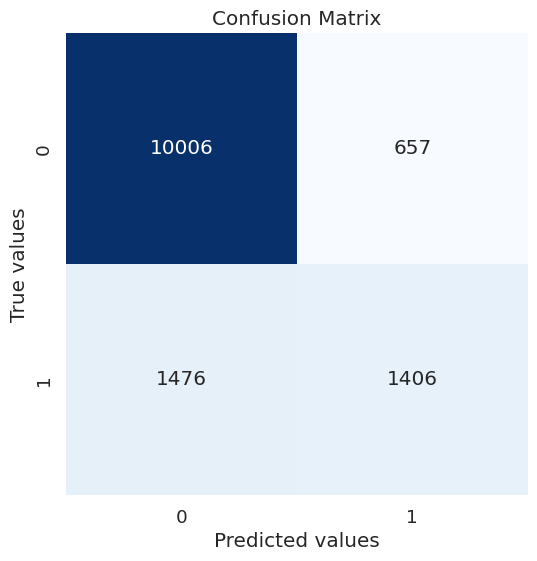

-------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     10663
         1.0       0.68      0.49      0.57      2882

    accuracy                           0.84     13545
   macro avg       0.78      0.71      0.74     13545
weighted avg       0.83      0.84      0.83     13545

-------------------------
Accuracy Train Set: 0.859 Accuracy Test Set: 0.843


In [29]:
y_pred_test_best= dt_best.predict(X_test)
y_pred_train_best = dt_best.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test_best, y_train, y_pred_train_best)

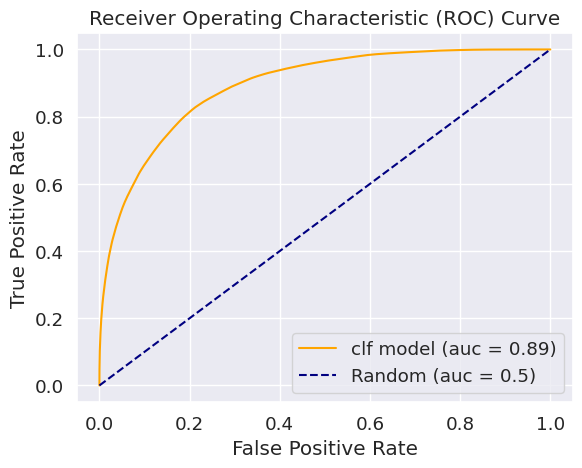

In [30]:
roc_curve_custom(dt_best, X_train, y_train)

Precision: It measures the accuracy of positive predictions. In this context, for class 0.0, the precision is 0.87, which means that when the model predicts an instance as belonging to class 0.0, it is correct 87% of the time. For class 1.0, the precision is 0.68, meaning the model is correct 68% of the time when predicting class 1.0.

Recall: It measures the ability of the model to capture all positive instances. For class 0.0, the recall is 0.94, indicating that the model correctly identifies 94% of all actual instances of class 0.0. For class 1.0, the recall is 0.49, indicating that the model captures 49% of all actual instances of class 1.0.

F1-score: It is the harmonic mean of precision and recall. It provides a balance between precision and recall. A high F1-score implies both high precision and high recall. In this case, for class 0.0, the F1-score is 0.90, and for class 1.0, it is 0.57.

Accuracy: It represents the proportion of correctly classified instances out of all instances. Here, the overall accuracy is 0.84, meaning the model correctly predicts the class for 84% of all instances.

Macro Avg: It calculates the average of the precision, recall, and F1-score across both classes, without considering class imbalance.

Weighted Avg: It calculates the average of the precision, recall, and F1-score, weighted by the number of instances in each class. This gives more weight to classes with more instances, which is useful when dealing with class imbalance.

As we can see, the model does a good job predicting class 0 but the precisin, recall and f1-score is quite low for class 1. That is most likley due to the imbalance of the dataset. So let's repeat the modelling process with over and undersampling techniques. 

### 2. Oversampling  

### 2.1 Random Oversampling 

In [32]:
ros = RandomOverSampler()
sample_ros = ros.fit_resample(data,target)

In [33]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(sample_ros[0], sample_ros[1], test_size=0.2, random_state=20)

In [34]:
dt_ros = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
dt_ros.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

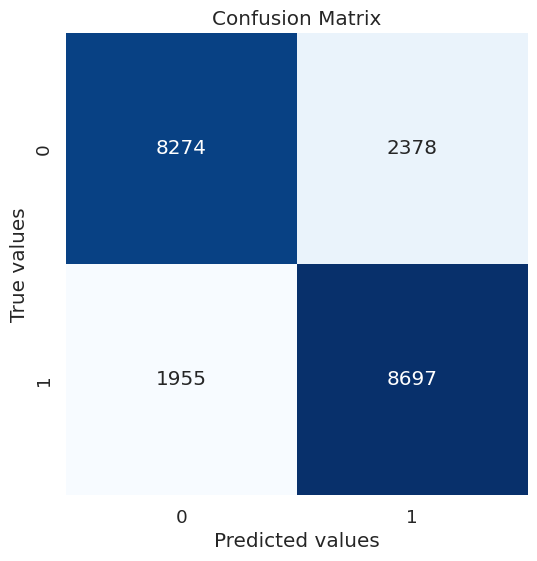

-------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79     10652
         1.0       0.79      0.82      0.80     10652

    accuracy                           0.80     21304
   macro avg       0.80      0.80      0.80     21304
weighted avg       0.80      0.80      0.80     21304

-------------------------
Accuracy Train Set: 0.805 Accuracy Test Set: 0.797


In [35]:
y_pred_test_ros= dt_ros.predict(X_test_ros)
y_pred_train_ros = dt_ros.predict(X_train_ros)
confusion_matrix_classification_report(y_test_ros, y_pred_test_ros, y_train_ros, y_pred_train_ros)

With random over sampling we get much better model performance for class 1. Now all the scores are over 0.75. Unfortunately the precision, recall and f1-score are lower than before for class 0. Let's try SMOTE oversampling to see if we get better scores. 

### 2.2 SMOTE

In [7]:
smo = SMOTE()
sample_sm = smo.fit_resample(data,target)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(sample_sm[0], sample_sm[1], test_size=0.2, random_state=20)

In [37]:
dt_sm = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
dt_sm.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

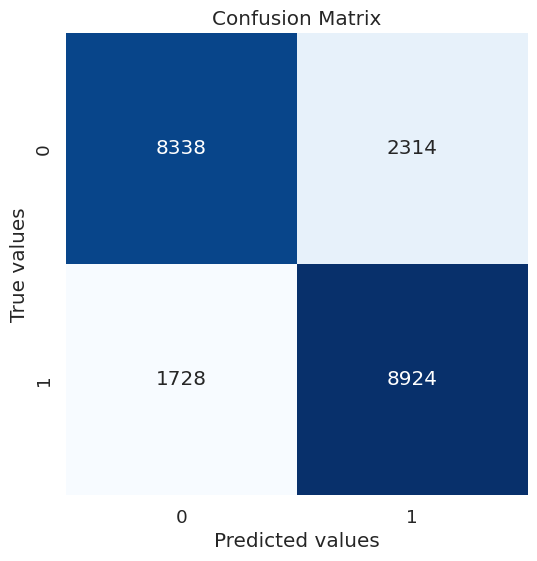

-------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80     10652
         1.0       0.79      0.84      0.82     10652

    accuracy                           0.81     21304
   macro avg       0.81      0.81      0.81     21304
weighted avg       0.81      0.81      0.81     21304

-------------------------
Accuracy Train Set: 0.821 Accuracy Test Set: 0.81


In [38]:
y_pred_test_sm= dt_sm.predict(X_test_sm)
y_pred_train_sm = dt_sm.predict(X_train_sm)
confusion_matrix_classification_report(y_test_sm, y_pred_test_sm, y_train_sm, y_pred_train_sm)

Smote seems to work better. No we get scores for all metrics over 0.80. Unfortunately the scores for class 1 are still lower than they were without any over sampling. 

### 3. Undersampling 

### 3.1 Radom Undersampling 

In [39]:
rus = RandomUnderSampler()
sample_rus = rus.fit_resample(data,target)

In [40]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(sample_rus[0], sample_rus[1], test_size=0.2, random_state=42)

In [41]:
dt_rus = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
dt_rus.fit(X_train_rus, y_train_rus)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

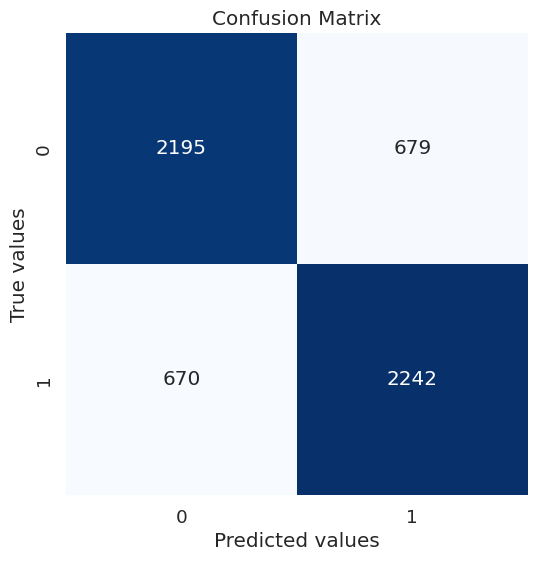

-------------------------
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76      2874
         1.0       0.77      0.77      0.77      2912

    accuracy                           0.77      5786
   macro avg       0.77      0.77      0.77      5786
weighted avg       0.77      0.77      0.77      5786

-------------------------
Accuracy Train Set: 0.808 Accuracy Test Set: 0.767


In [43]:
y_pred_test_rus= dt_rus.predict(X_test_rus)
y_pred_train_rus = dt_rus.predict(X_train_rus)
confusion_matrix_classification_report(y_test_rus, y_pred_test_rus, y_train_rus, y_pred_train_rus)

Compared to SMOTE, we do not seem to get better results with random over sampling. 

### 4. Conclusion Over/Undersampling

From all the over and undersampling methods SMOTE shows the best results. So let's do some hyperparameter tuning with SMOTE and see if get an even better result. 

### 5. Hyperparameter tuning with SMOTE 

### 5.1 GridSearchCV

In [10]:
dtree_model = DecisionTreeClassifier(random_state=42)
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 12)}
nfolds = 5

In [11]:
grid_dt = GridSearchCV(dtree_model, param_grid, cv=nfolds)

### 5.2 Best Parameter Fit 

In [12]:
dt_sm_fit = grid_dt.fit(X_train_sm, y_train_sm)

In [14]:
dump(dt_sm_fit, 'dt_sm_fit.joblib')

['dt_sm_fit.joblib']

In [15]:
dt_sm_fit = load('dt_sm_fit.joblib')
dt_sm_fit.best_params_

{'criterion': 'gini', 'max_depth': 11}

In [16]:
dt_best = DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)
dt_best.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)

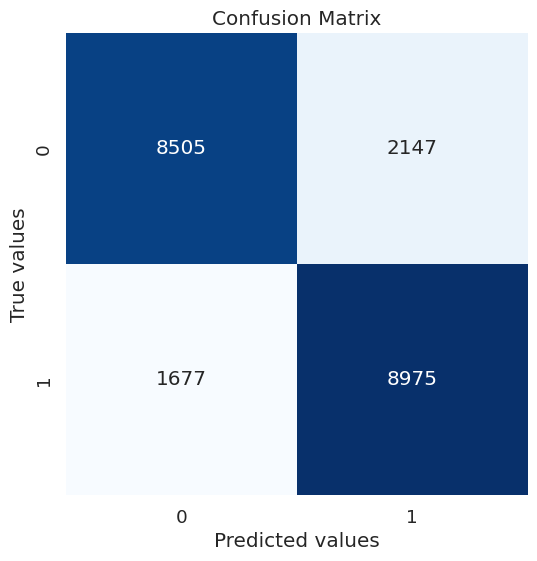

-------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82     10652
         1.0       0.81      0.84      0.82     10652

    accuracy                           0.82     21304
   macro avg       0.82      0.82      0.82     21304
weighted avg       0.82      0.82      0.82     21304

-------------------------
Accuracy Train Set: 0.85 Accuracy Test Set: 0.821


In [17]:
y_pred_test_best= dt_best.predict(X_test_sm)
y_pred_train_best = dt_best.predict(X_train_sm)
confusion_matrix_classification_report(y_test_sm, y_pred_test_best, y_train_sm, y_pred_train_best)

The hyperparameter tuning allowed us to get slighlty better results.

### 6. Boosting with SMOTE

In [18]:
ac = AdaBoostClassifier(base_estimator=dt_best,n_estimators=400)
ac.fit(X_train_sm,y_train_sm)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

In [19]:
dt_ac_fit = ac
dump(dt_ac_fit, 'dt_ac_fit.joblib')

['dt_ac_fit.joblib']

In [20]:
dt_ac_fit = load('dt_ac_fit.joblib')

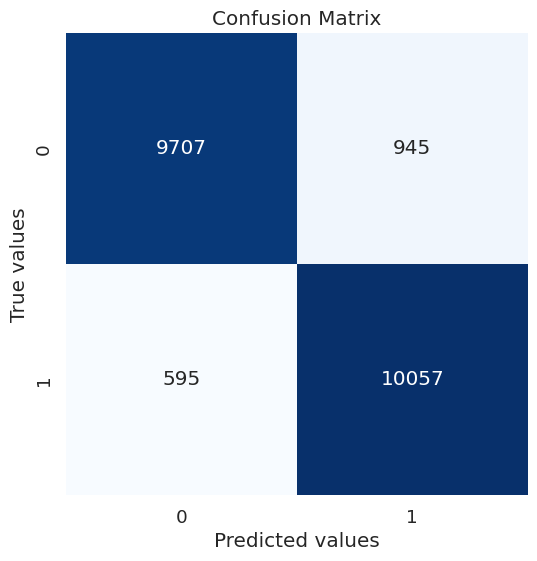

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     10652
         1.0       0.91      0.94      0.93     10652

    accuracy                           0.93     21304
   macro avg       0.93      0.93      0.93     21304
weighted avg       0.93      0.93      0.93     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.928


In [21]:
y_pred_ac = dt_ac_fit.predict(X_test_sm)
y_pred_train_ac = dt_ac_fit.predict(X_train_sm)
confusion_matrix_classification_report(y_test_sm, y_pred_ac, y_train_sm, y_pred_train_ac)

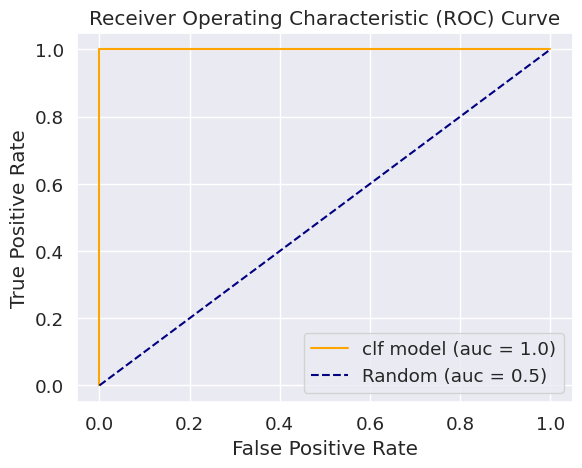

In [22]:
roc_curve_custom(dt_ac_fit, X_train_sm, y_train_sm)

Boosting definitely helped. No all the scores of class 0 and 1 are over 1 and the model has a great performance. The ROC curve confirms that result. 

### 7. Cross Validation 

In [26]:
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

cv_results = cross_validate(dt_ac_fit, X_train_sm, y_train_sm, cv=5, return_estimator=True, scoring=scoring)
print(cv_results)

{'fit_time': array([277.25355506, 285.95201564, 278.25154543, 276.88961363,
       276.73350453]), 'score_time': array([0.97625923, 1.01067185, 0.97274041, 0.96524739, 0.96641827]), 'estimator': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400), AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400), AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400), AdaBoostClassifier

In [27]:
dump(cv_results, 'dt_cv_results.joblib')

['dt_cv_results.joblib']

In [28]:
dt_cv_results = load('dt_cv_results.joblib')

In [29]:
from tabulate import tabulate
fold_numbers = range(1,11)
test_precision = dt_cv_results['test_precision']
test_recall = dt_cv_results['test_recall']
test_f1_score = dt_cv_results['test_f1_score']
table = [["Fold", "Test Precision", "Test Recall", "Test F1-Score"]]
for fold, prec, recall, f1 in zip(fold_numbers, test_precision, test_recall, test_f1_score):
    table.append([fold, f"{prec:.3f}", f"{recall:.3f}", f"{f1:.3f}"])

# Print table
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

+------+----------------+-------------+---------------+
| Fold | Test Precision | Test Recall | Test F1-Score |
+------+----------------+-------------+---------------+
|  1   |     0.921      |    0.920    |     0.920     |
|  2   |     0.923      |    0.922    |     0.922     |
|  3   |     0.921      |    0.920    |     0.920     |
|  4   |     0.919      |    0.919    |     0.919     |
|  5   |     0.925      |    0.925    |     0.925     |
+------+----------------+-------------+---------------+


### 8. Feature Importance

Feature ranking:
1. feature 5 (0.388231) - Sunshine
2. feature 6 (0.142808) - WindGustSpeed
3. feature 13 (0.123471) - Humidity
4. feature 10 (0.073547) - Cloud
5. feature 11 (0.069802) - Pressure
6. feature 3 (0.051242) - Rainfall
7. feature 9 (0.032371) - Longitude
8. feature 8 (0.027334) - Latitude
9. feature 7 (0.020306) - WindGustDir_angle
10. feature 12 (0.019545) - Temperature
11. feature 14 (0.017635) - temp_fluctuation
12. feature 4 (0.012636) - Evaporation
13. feature 2 (0.008483) - RainToday
14. feature 1 (0.007634) - Month
15. feature 0 (0.004955) - Year


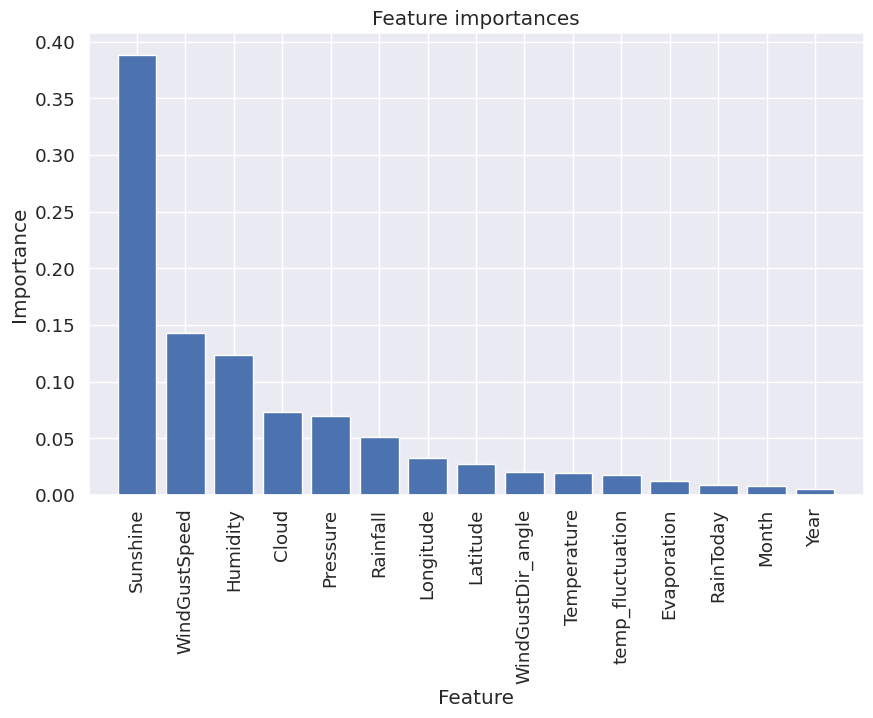

In [30]:
column_names= data.columns 
importances = dt_best.feature_importances_

# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train_sm.shape[1]):
    print("%d. feature %d (%f) - %s" % (f + 1, indices[f], importances[indices[f]], column_names[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train_sm.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train_sm.shape[1]), [column_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_sm.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

### 9. Conclusion 

We get the best result with SMOTE over sampling, hyperparameter tuning and boosting with the best parameters: 

We get the following results when applying the SMOTE and the best parameters to boosting: 

Precision: It measures the accuracy of the positive predictions. For class 0.0, it's 94%, and for class 1.0, it's 91%. This means that when the model predicts a class, it is correct 94% of the time for class 0.0 and 91% of the time for class 1.0.

Recall: It measures the ability of the model to capture all the positive instances. For class 0.0, it's 91%, and for class 1.0, it's 95%. This means that the model correctly identifies 91% of all actual instances of class 0.0 and 95% of all actual instances of class 1.0.

F1-score: It's the harmonic mean of precision and recall. It provides a balance between precision and recall. For both classes, it's 93%.

Support: It's the number of actual occurrences of the class in the specified dataset. For class 0.0, it's 10652, and for class 1.0, it's also 10652.

Accuracy: Overall accuracy of the model, which is 93%. It represents the proportion of correctly classified instances out of all instances.

Macro avg: It's the average of the precision, recall, and F1-score across both classes, giving equal weight to each class. Here, it's also 93%.

Weighted avg: It's the weighted average of precision, recall, and F1-score, where each metric is weighted by the number of true instances for each class. It's useful when there's class imbalance. Here, it's also 93%.

The accuracy scores provided separately for the train and test sets show how well the model performs on the data it was trained on versus unseen data. In this case, the model has a perfect accuracy of 100% on the train set and an accuracy of 92.9% on the test set, which indicates good generalization performance.Precision: It measures the accuracy of the positive predictions. For class 0.0, it's 94%, and for class 1.0, it's 91%. This means that when the model predicts a class, it is correct 94% of the time for class 0.0 and 91% of the time for class 1.0.

Finally for the feature importance, the single most important feature seems to be the hours of sunshine, followed by the Rainfall in mm and the pressure. 